# Generating new images with Variational AutoEncoders

In this example we will implement a  Varaiational Autoencoder (VAE) for generating new MNIST images using tensorflow 2.0/Keras.

This example is partially based on https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

We'll start with the imports:

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.markers import MarkerStyle
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model

In [56]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1] * x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size])
x_test = np.reshape(x_test, [-1, image_size])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Immediately tied to the network definition is the `samping` function, which implements a random sampling of tlatent vectors z from the Gausssian unit

In [57]:
def sampling(args):
     # unpack the input tuple
    z_mean, z_log_var = args
    # mini-batch-size
    mb_size = K.shape(z_mean)[0]
    # latent space size
    dim = K.int_shape(z_mean)[1]
    # random normal vector with mean=0 and std=1.0
    epsilon = K.random_normal(shape=(mb_size, dim))
    return z_mean + K.exp(0.5* z_log_var) * epsilon

In [58]:
def build_vae(intermediate_dim=512, latent_dim=2):
    """Build VAE.
    
    :param intermediate_dim: size of the hidden layers of the encoder/decoder
    :param latent_dim: latent space size
    :returns tuple: the encoder, the decoder, and full vae
    """
    # Encoder first
    inputs = Input(shape=(image_size,), name="encoder_input")
    x = Dense(intermediate_dim, activation="relu")(inputs)
    # latent mean and variance
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    
    # Reparameterization trick for random sampling
    # note the use of the Lambda Layer
    # at runtime, it will call the simpling function
    z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

    # full encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    # decoder
    latent_inputs = Input(shape=(latent_dim, ), name="z_sampling")
    x = Dense(intermediate_dim, activation="relu")(latent_inputs)
    outputs = Dense(image_size, activation="sigmoid")(x)
    # full decoder model
    decoder = Model(latent_inputs, outputs, name="decoder")
    decoder.summary()
    # VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name="vae")
    # Loss function
    # we start with the reconstruction loss
    reconstruction_loss = binary_crossentropy(inputs, outputs) * image_size
    
    # next is the KL divergence
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss*= -0.5
    
    # we combine them in a total loss
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    return encoder, decoder, vae

Next, we will use the Adam optimizer to train the network for 50 epochs

In [59]:
encoder, decoder, vae = build_vae()

vae.compile(optimizer='adam')
vae.summary()
    

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_18[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_18[0][0]                   
____________________________________________________________________________________________

In [60]:
vae.fit(x_train,
       epochs=50,
       batch_size=128,
       validation_data=(x_test, None))


2025-01-31 06:38:30.311297: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 188160000 exceeds 10% of system memory.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 105us/sample - loss: 198.6022 - val_loss: 174.4566
Epoch 2/50
60000/60000 [==============================] - 6s 96us/sample - loss: 171.8459 - val_loss: 168.2935
Epoch 3/50
60000/60000 [==============================] - 6s 94us/sample - loss: 166.7304 - val_loss: 164.4322
Epoch 4/50
60000/60000 [==============================] - 6s 94us/sample - loss: 163.3988 - val_loss: 162.1698
Epoch 5/50
60000/60000 [==============================] - 6s 93us/sample - loss: 161.1822 - val_loss: 160.4023
Epoch 6/50
60000/60000 [==============================] - 6s 96us/sample - loss: 159.4206 - val_loss: 158.5660
Epoch 7/50
60000/60000 [==============================] - 6s 103us/sample - loss: 157.9159 - val_loss: 157.2753
Epoch 8/50
60000/60000 [==============================] - 6s 104us/sample - loss: 156.7085 - val_loss: 156.4749
Epoch 9/50
60000/60000 [==============================] - 6

Now, we need to implement the `plot_latent_distibution` function. It collects the latent representations of all the images in the test set and displays them over a 2D plot. We can do this because our network has only two latent variables

In [63]:
def plot_latent_distribution(encoder,
                             x_test,
                             y_test,
                             batch_size=128):
    """
    Display a 2D plot of the digit classes in the latent space.
    We are interested only in z, so we only need the encoder here.
    :param encoder: the encoder network
    :param x_test: test images
    :param y_test: test labels
    :param batch_size: size of the mini-batch
    """
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 12))

    markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 's', 'p')

    for i in np.unique(y_test):
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],
                    marker=MarkerStyle(markers[i], fillstyle='none'),
                    edgecolors='black')

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
    


We can see the results of the training by first plotting the latent distribution of the test images, produced by the encoder:

/home/victord/git/Advanced-Deep-Learning-with-Python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f5671234f90>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/victord/git/Advanced-Deep-Learning-with-Python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f55f75be810>).  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
/home/victord/git/Advanced-Deep-Learning-with-Python/venv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker (<matplotlib.markers.MarkerStyle object at 0x7f55f7548610>).  Matplotlib is ignoring the e

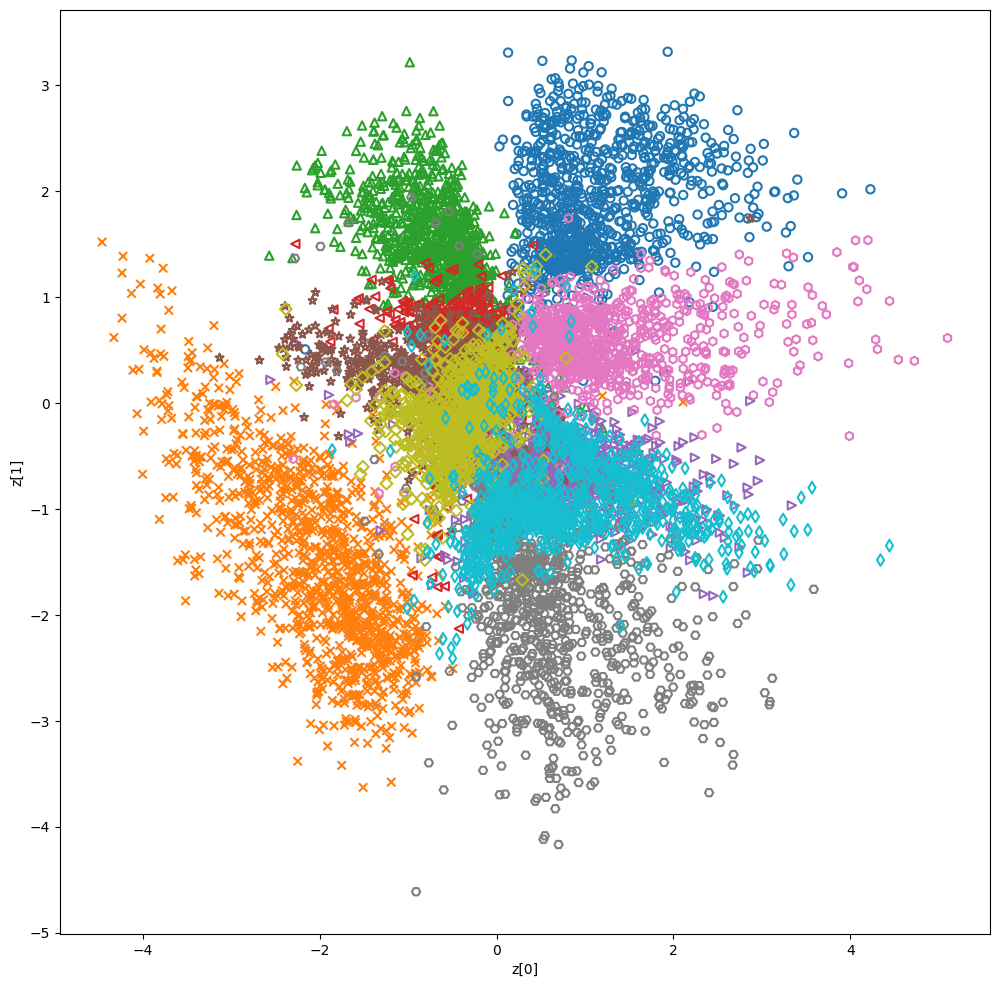

In [64]:
plot_latent_distribution(encoder,
                         x_test,
                         y_test,
                         batch_size=128)

We'll continue with another visualization, plot_generated_images, which will create a grid of newly generated decoder images, given certain distribution of the 2 cells of the latent vector. The x,y grid coordinates reflect the values of the 2 cells of the latent vector:

In [69]:
def plot_generated_images(decoder):
    """
    Display a 2D plot of the generated images.
    We only need the decoder, because we'll manually sample the distribution z
    :param decoder: the decoder network
    """

    # display a nxn 2D manifold of digits
    n = 15
    digit_size = 28

    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    # start sampling z1 and z2 in the ranges grid_x and grid_y
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = digit

    # plot the results
    plt.figure(figsize=(15, 12))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    # Ensure the number of tick labels matches the number of tick locations
    plt.xticks(pixel_range[:len(sample_range_x)], sample_range_x)
    plt.yticks(pixel_range[:len(sample_range_y)], sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

Finally, let's see a set of newly generated decoder images:

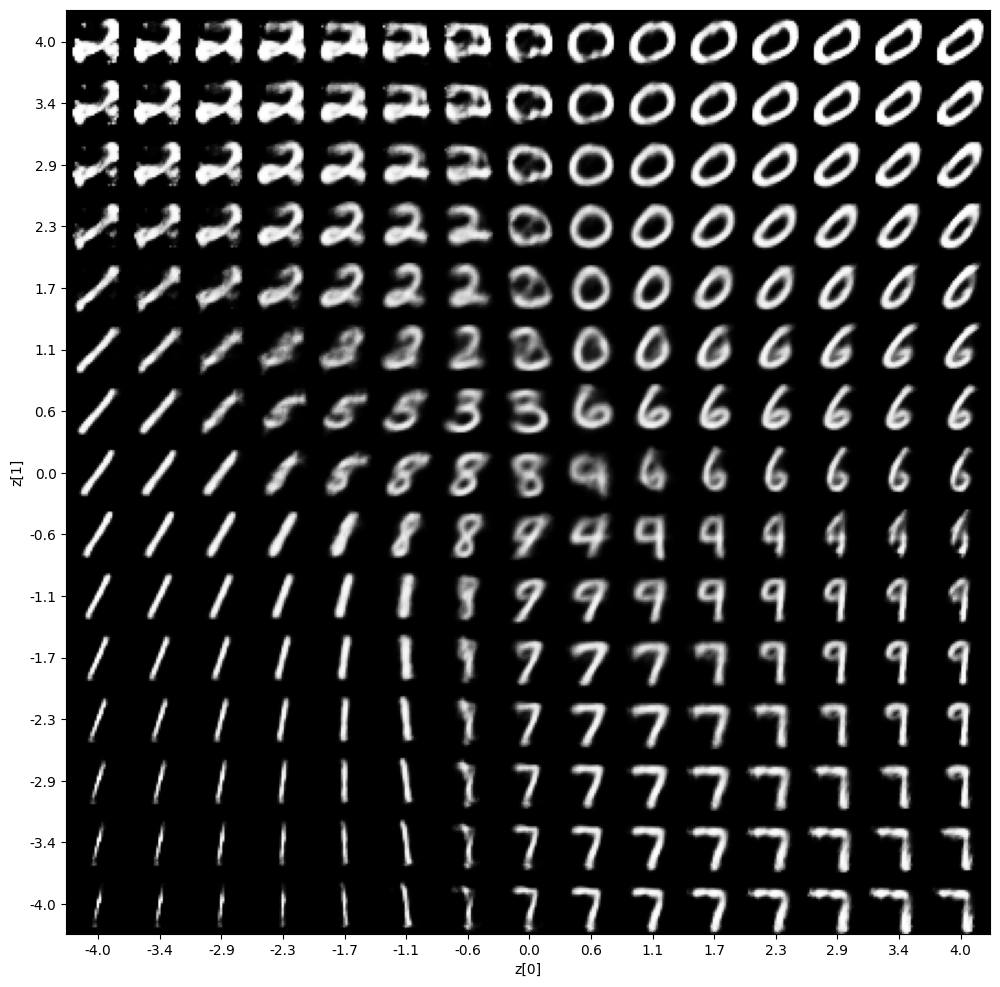

In [70]:
plot_generated_images(decoder)